In [41]:
# useful packages
import numpy as np
import csv
import math
import pandas as pd
from sklearn import preprocessing
from sklearn import datasets
from sklearn import cluster
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objects as pgo
import tensorflow as tf
from tensorflow import keras

from mpl_toolkits.mplot3d import Axes3D

In [42]:
# load data as a dataframe with pandas
user_history = pd.read_csv("user_history.csv")
user_history_without_user_ID = user_history.drop(['USER ID'],axis=1)
user_ratings = pd.read_csv("user_ratings.csv")

In [43]:
user_history.shape

(4500, 101)

In [44]:
user_ratings.shape

(33725, 3)

To get a better sense of the data, using pandas, you can look at the top 5 rows using the head function:

In [45]:
user_history.head()

,USER ID,alpine kimono,sweden kansas,student icon,supreme ivan,albert charlie,heavy trapeze,fabric tokyo,brother robin,tiger catalog,...,cigar lagoon,equal comedy,bombay podium,helena robot,prodigy rhino,jumbo gray,radius wizard,fame quiz,bazaar complex,glass slogan
0,100950,2.192897,0.361397,0.531663,0.016105,0.694338,1.250662,1.483259,1.799682,0.664616,...,0.309236,2.622033,1.242243,2.947560,0.693319,0.625303,2.352295,1.548417,1.517709,1.508219
1,100956,2.776597,0.788821,1.187149,0.473049,2.245112,1.998881,0.072812,1.441970,2.264368,...,2.304845,1.498307,0.319484,0.089212,3.157167,2.789594,1.003377,1.141516,2.011509,0.377898
2,100962,0.281717,5.046727,4.407484,2.138591,1.075562,0.385842,0.626482,0.026648,1.949374,...,1.463952,0.601814,1.983130,2.364877,0.429133,2.758070,0.563619,0.271453,0.579626,1.785609
3,100969,0.943147,1.165713,2.016138,1.236626,0.973435,2.514205,0.022476,1.091282,1.320748,...,1.428416,3.791742,1.102070,3.250911,1.209403,0.246261,0.558631,1.163652,1.922758,1.008040
4,100974,0.485729,4.633607,4.120416,1.497073,1.463875,0.867737,0.877514,0.019603,1.751483,...,1.179954,1.031741,1.935182,2.012611,0.553173,2.614605,0.313479,0.143246,0.914407,2.011048


In [46]:
user_ratings.head()

,USER ID,PRODUCT,RATING
0,100950,secret postage,4
1,100950,violet saga,4
2,100950,pepper chicago,3
3,100950,nina sailor,2
4,100950,front salami,3


In [47]:
user_ratings_table = pd.pivot_table(user_ratings,values='RATING', index='USER ID',
                    columns='PRODUCT')
user_ratings_table.head()

PRODUCT,adrian crater,anagram mentor,apropos pizza,bandit anatomy,banjo ladder,barcode arnold,bazooka diagram,bronze mystic,calypso zigzag,casino unit,...,tourist micro,tripod stand,update lola,ventura puzzle,viking llama,violet saga,vista queen,viva avalon,voodoo planet,wheel gibson
USER ID,,,,,,,,,,,,,,,,,,,,,
100950,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
100956,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100969,NaN,10.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,0.0,NaN,NaN,8.0,2.0
100974,NaN,NaN,NaN,9.0,NaN,5.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN


In [48]:
np.sum(~np.isnan(user_ratings_table.to_numpy()))

33725

In [49]:
# encode users as indices
le_user = preprocessing.LabelEncoder()
le_user.fit(user_history['USER ID'])

user_with_rating_index = le_user.transform(user_ratings['USER ID'])
all_user_index = le_user.transform(user_history['USER ID'])
user_ratings['USER INDEX'] = user_with_rating_index
user_ratings.head()

# encode products as indices
le_product = preprocessing.LabelEncoder()
le_product.fit(user_ratings['PRODUCT'])

product_ID = le_product.transform(user_ratings['PRODUCT'])
user_ratings['PRODUCT ID'] = product_ID
user_ratings.head()

,USER ID,PRODUCT,RATING,USER INDEX,PRODUCT ID
0,100950,secret postage,4,0,54
1,100950,violet saga,4,0,70
2,100950,pepper chicago,3,0,41
3,100950,nina sailor,2,0,35
4,100950,front salami,3,0,18


We can take the data in user_history and turn it into a matrix using the following command:

In [50]:
X = user_history.to_numpy()

In [51]:
user_history

,USER ID,alpine kimono,sweden kansas,student icon,supreme ivan,albert charlie,heavy trapeze,fabric tokyo,brother robin,tiger catalog,...,cigar lagoon,equal comedy,bombay podium,helena robot,prodigy rhino,jumbo gray,radius wizard,fame quiz,bazaar complex,glass slogan
0,100950,2.192897,0.361397,0.531663,0.016105,0.694338,1.250662,1.483259,1.799682,0.664616,...,0.309236,2.622033,1.242243,2.947560,0.693319,0.625303,2.352295,1.548417,1.517709,1.508219
1,100956,2.776597,0.788821,1.187149,0.473049,2.245112,1.998881,0.072812,1.441970,2.264368,...,2.304845,1.498307,0.319484,0.089212,3.157167,2.789594,1.003377,1.141516,2.011509,0.377898
2,100962,0.281717,5.046727,4.407484,2.138591,1.075562,0.385842,0.626482,0.026648,1.949374,...,1.463952,0.601814,1.983130,2.364877,0.429133,2.758070,0.563619,0.271453,0.579626,1.785609
3,100969,0.943147,1.165713,2.016138,1.236626,0.973435,2.514205,0.022476,1.091282,1.320748,...,1.428416,3.791742,1.102070,3.250911,1.209403,0.246261,0.558631,1.163652,1.922758,1.008040
4,100974,0.485729,4.633607,4.120416,1.497073,1.463875,0.867737,0.877514,0.019603,1.751483,...,1.179954,1.031741,1.935182,2.012611,0.553173,2.614605,0.313479,0.143246,0.914407,2.011048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,125614,0.200730,3.819307,3.793920,1.352770,1.616516,0.138227,0.193954,0.770098,1.724992,...,0.985254,0.508837,2.033624,2.783638,0.360851,1.787872,0.749357,0.205445,0.945106,1.155107
4496,125622,1.139876,0.361305,1.420300,1.024918,2.313955,1.638803,1.570336,0.233047,1.521743,...,3.606324,1.670899,1.127929,1.888831,4.198021,2.934536,0.501603,0.923039,0.737211,0.675006
4497,125629,2.423679,0.555591,1.244828,0.100391,1.098254,2.027846,1.485342,0.912006,0.304603,...,0.050602,2.439248,1.352124,2.926793,0.254287,0.488679,2.181696,1.367859,1.410247,0.549376
4498,125636,0.096291,3.028528,2.554836,0.404308,1.401119,0.760813,0.356988,1.873021,1.977173,...,0.609813,0.242120,1.061562,2.616126,0.091176,1.162114,1.218459,1.067140,0.441260,0.666655


In [52]:
X[:,1:].shape

(4500, 100)

In [53]:
X_data=X[:,1:]
X_data.shape

(4500, 100)

In [54]:
X_data_meanzero = X_data - np.mean(X_data, axis=1, keepdims=True)# subtract the mean
X_data_std = X_data_meanzero/np.std(X_data_meanzero, axis=1, keepdims=True)# divide by the standard deviation

In [55]:

U, S, VT = np.linalg.svd(X_data_std, full_matrices=False)


svd_figure = pgo.Figure([pgo.Bar(x=np.arange(len(S)), y=S)])
svd_figure.show()

In [56]:
X_data_std.shape

(4500, 100)

In [57]:
print((S[0] ** 2 + S[1] ** 2+ S[2] ** 2) / np.sum(np.power(S, 2)))
print((S[0] ** 2 + S[1] ** 2+ S[2] ** 2+ S[3] ** 2+ S[4] ** 2+ S[5] ** 2+ S[6] ** 2+ S[7] ** 2+ S[8] ** 2+ S[9] ** 2) / np.sum(np.power(S, 2)))

0.8354402230823958
0.9523317644046461


### The first three dimensions contribute the most, we could use the first 3 and the following 7 dimensions.

In [58]:
X_pcbasis.shape

(4500, 100)

In [59]:
# compute 2-dimensional projection
X_pcbasis = X_data_std @ VT.T


projection = pgo.Figure(data=pgo.Scatter(x=X_pcbasis[0], y=X_pcbasis[1], mode="markers", marker=dict(
        size=16,
        color=X[:,0:1], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))
projection.update_layout(showlegend=False)
projection.show()

In [60]:
# compute 2-dimensional projection
X_pcbasis = X_data_std @ VT.T


projection = pgo.Figure(data=pgo.Scatter(x=X_pcbasis[0], y=X_pcbasis[1], mode="markers", marker=dict(
        size=16,
        color=X[:,0:1], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))
projection.update_layout(showlegend=False)


projection.show()

In [61]:
# compute 2-dimensional projection
X_pcbasis = X_data_std @ VT.T


projection = pgo.Figure(data=pgo.Scatter(x=X_pcbasis[1], y=X_pcbasis[2], mode="markers", marker=dict(
        size=16,
        color=X[:,0:1], #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )))
projection.update_layout(showlegend=False)
projection.show()

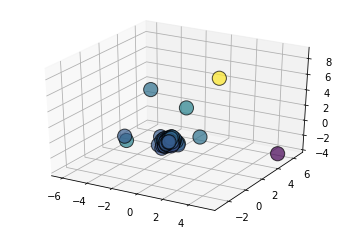

In [62]:
# compute 2-dimensional projection
X_pcbasis = X_data_std @ VT.T

x=X_pcbasis[1]
y=X_pcbasis[2]
z=X_pcbasis[0]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()

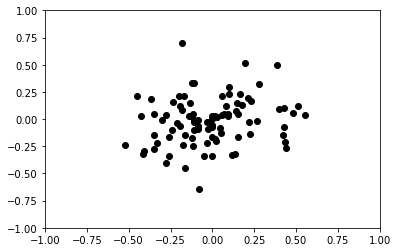

In [63]:
x=X_pcbasis[0]
y=X_pcbasis[1]
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.plot(x, y, 'o', color='black');

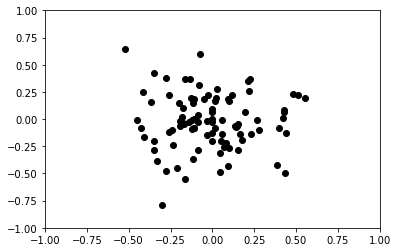

In [64]:
x=X_pcbasis[0]
y=X_pcbasis[2]
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.plot(x, y, 'o', color='black');

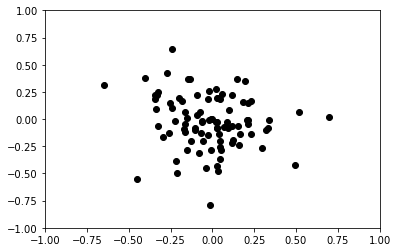

In [65]:
x=X_pcbasis[1]
y=X_pcbasis[2]
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.plot(x, y, 'o', color='black');

In [66]:
X_pcbasis.shape

(4500, 100)

In [67]:
# compute 3-dimensional projection


Three_d_data=X_pcbasis[0:3]

fig = pgo.Figure(data=[pgo.Surface(z=Three_d_data)])
fig.update_layout(title='3-D Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()


In [68]:
fashion_mnist = keras.datasets.fashion_mnist

In [69]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

In [70]:
train_labels.shape

(60000,)

In [79]:
train_images.shape

(60000, 28, 28)

In [80]:
all_data=pd.merge(user_history,user_ratings_table,right_index=True,left_on='USER ID',how='outer' )


In [81]:
all_data.shape

(4500, 176)

In [82]:
all_data_train_frame=all_data.head(3500)
all_data_test_frame=all_data.head(-3500)

In [94]:
all_data_train=pd.DataFrame(all_data_train_frame).to_numpy()

In [95]:
all_data_train[0,101:176].shape

(75,)

In [96]:
all_data_train_percentage=[]

In [97]:
for i in range(3500):
    all_data_train_percentage.append(all_data_train[i,1:101])

In [98]:
all_data_train_ratings=[]
for i in range(3500):
    all_data_train_ratings.append(all_data_train[i,101:176])

In [99]:
all_data_train_ratings[0].shape

(75,)

In [100]:
all_data_train_ratings[0]

array([nan, nan, nan, nan,  8., nan, nan, nan,  5., nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  3., nan, nan, nan, nan, nan,  8., nan,
       nan, nan,  4., nan, nan,  6., nan,  6.,  9.,  2., nan, nan, nan,
       nan, nan,  3., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  4., nan, nan,  1., nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan,  4., nan, nan, nan, nan])

In [101]:
for i in range(3500):
    for j in range(75):
        if math.isnan(all_data_train_ratings[i][j]):
            all_data_train_ratings[i][j]=5

In [102]:
all_data_train_ratings[6]

array([ 9.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  3.,  6.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5., 10.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  7.,  0.,  5.,  5.,  3.,  5.,  5.,  5.,  5.,  5.,  7.,  5.,
        5.,  5.,  5.,  8.,  6.,  5.,  5.,  5.,  5.,  5.])

In [103]:
all_data_train_percentage[786]

array([3.606305, 2.496564, 3.08026 , 0.593583, 0.666814, 3.175655,
       1.573368, 1.244385, 0.607705, 2.413242, 0.557384, 2.099452,
       1.705052, 1.035132, 1.180987, 1.692976, 2.817725, 1.295659,
       2.898921, 0.663857, 4.233636, 1.161895, 0.259272, 0.182842,
       0.181632, 3.936523, 1.373642, 2.327691, 0.344288, 0.141794,
       1.302065, 1.105662, 0.155664, 0.788541, 3.491167, 0.413096,
       1.449681, 2.729544, 0.390549, 0.749617, 0.622331, 0.627859,
       0.695862, 2.600174, 0.35928 , 5.11767 , 1.000614, 1.405645,
       2.380993, 1.978733, 1.192365, 3.764957, 3.081575, 2.465441,
       0.557465, 0.40447 , 1.763479, 6.148906, 1.862952, 0.131506,
       0.068253, 1.516563, 0.9917  , 3.551007, 0.324183, 0.078999,
       1.890033, 2.742462, 1.254785, 1.463102, 1.373652, 1.750909,
       1.709247, 0.421581, 0.924017, 1.076305, 3.68832 , 2.257766,
       1.636333, 0.115051, 2.611679, 2.021759, 0.820628, 2.219856,
       1.577273, 0.840077, 2.028356, 0.68676 , 0.30943 , 0.082

In [104]:
model=keras.Sequential([
    keras.layers.Flatten(input_shape=(100,)),
    keras.layers.Dense(1000,activation=tf.nn.relu),
    keras.layers.Dense(75,activation=tf.nn.softmax)
])

In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_3 (Dense)              (None, 75)                75075     
Total params: 176,075
Trainable params: 176,075
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.categorical_crossentropy,metrics=['accuracy'])

In [107]:
model.compile(optimizer=tf.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])

In [108]:
model.fit(np.array(all_data_train_percentage),np.array(all_data_train_ratings),epochs=100)

Epoch 1/100
110/110 [==============================] - 0s 1ms/step - loss: 25.8009 - accuracy: 0.0380
Epoch 2/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7981 - accuracy: 0.0537
Epoch 3/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7964 - accuracy: 0.0614
Epoch 4/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7954 - accuracy: 0.0677
Epoch 5/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7946 - accuracy: 0.0754
Epoch 6/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7943 - accuracy: 0.0977
Epoch 7/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7938 - accuracy: 0.0840
Epoch 8/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7935 - accuracy: 0.0886
Epoch 9/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7931 - accuracy: 0.0971
Epoch 10/100
110/110 [==============================] - 0s 1ms/step - loss: 25.793

110/110 [==============================] - 0s 1ms/step - loss: 25.7745 - accuracy: 0.2457
Epoch 81/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7746 - accuracy: 0.2400
Epoch 82/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7740 - accuracy: 0.2549
Epoch 83/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7734 - accuracy: 0.2526
Epoch 84/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7728 - accuracy: 0.2614
Epoch 85/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7731 - accuracy: 0.2571
Epoch 86/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7721 - accuracy: 0.2600
Epoch 87/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7720 - accuracy: 0.2640
Epoch 88/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7712 - accuracy: 0.2760
Epoch 89/100
110/110 [==============================] - 0s 1ms/step - loss: 25.7717 - 

In [72]:
len([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])

3500

In [168]:
model.compile(optimizer=tf.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
model.fit(np.array(all_data_train_percentage),np.array(all_data_train_ratings),epochs=100)

Epoch 1/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1729
Epoch 2/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 3/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 4/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 5/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 6/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 7/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 8/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 9/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 10/100
110/110 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1751
Epoch 11/100
110/11

In [173]:
model.compile(optimizer=tf.optimizers.Adam(),loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
model.fit(np.array(all_data_train_percentage),np.array(all_data_train_ratings),epochs=500)

Epoch 1/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7682 - accuracy: 0.2837
Epoch 2/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7665 - accuracy: 0.3051
Epoch 3/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7666 - accuracy: 0.2949
Epoch 4/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7657 - accuracy: 0.3089
Epoch 5/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7660 - accuracy: 0.3034
Epoch 6/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7658 - accuracy: 0.3046
Epoch 7/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7657 - accuracy: 0.3023
Epoch 8/500
110/110 [==============================] - ETA: 0s - loss: 25.7738 - accuracy: 0.305 - 0s 1ms/step - loss: 25.7653 - accuracy: 0.3054
Epoch 9/500
110/110 [==============================] - 0s 2ms/step - loss: 25.7651 - accuracy: 0.3114
Epoch 10/500
110/110 [================

110/110 [==============================] - 0s 1ms/step - loss: 25.7500 - accuracy: 0.4111
Epoch 158/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7501 - accuracy: 0.4111
Epoch 159/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7500 - accuracy: 0.4111
Epoch 160/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7507 - accuracy: 0.4083
Epoch 161/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7514 - accuracy: 0.4054
Epoch 162/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7499 - accuracy: 0.4131
Epoch 163/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7495 - accuracy: 0.4134
Epoch 164/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7497 - accuracy: 0.4137
Epoch 165/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7498 - accuracy: 0.4120
Epoch 166/500
110/110 [==============================] - 0s 1ms/step - loss: 2

110/110 [==============================] - 0s 1ms/step - loss: 25.7476 - accuracy: 0.4197
Epoch 236/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7474 - accuracy: 0.4220
Epoch 237/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7475 - accuracy: 0.4237
Epoch 238/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7476 - accuracy: 0.4266
Epoch 239/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7478 - accuracy: 0.4223
Epoch 240/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7484 - accuracy: 0.4251
Epoch 241/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7493 - accuracy: 0.4217
Epoch 242/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7548 - accuracy: 0.3849
Epoch 243/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7529 - accuracy: 0.3931
Epoch 244/500
110/110 [==============================] - 0s 1ms/step - loss: 2

110/110 [==============================] - 0s 1ms/step - loss: 25.7456 - accuracy: 0.4374
Epoch 391/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7455 - accuracy: 0.4371
Epoch 392/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7456 - accuracy: 0.4374
Epoch 393/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7456 - accuracy: 0.4363
Epoch 394/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7456 - accuracy: 0.4409
Epoch 395/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7456 - accuracy: 0.4371
Epoch 396/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7456 - accuracy: 0.4389
Epoch 397/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7456 - accuracy: 0.4360
Epoch 398/500
110/110 [==============================] - 0s 1ms/step - loss: 25.7457 - accuracy: 0.4346
Epoch 399/500
110/110 [==============================] - 0s 1ms/step - loss: 2

In [4]:
A=np.array([[4,20,31],[6,-5,-6],[2,-11,-16]])

In [7]:
np.linalg.matrix_rank(A)

2